In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

In [21]:
a=(0,3,4)

In [36]:
y=tuple([a[x] if x>0 else 99 for x in range(len(a))])

In [38]:
y

(99, 3, 4)

In [2]:
def train():
    Train = pd.read_csv('diabetes.csv')
    Train.head()
    print(pd.isnull(Train).any().any())
    if(pd.isnull(Train).any().any()):
        print(" Error :missing value in dataset")
        return



    X =Train[Train.columns[:-1]]
    y=Train[Train.columns[-1]]

    x = X.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()

    x_scaled = min_max_scaler.fit_transform(x)
    X = x_scaled
    y=y.values
    x.shape
    return X,y
X,y=train()

False


In [3]:

# direct data without preprocessing 
y=y
X=X

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.20, random_state=1994)
X_train, X_test, y_train, y_test=np.array(X_train).T, \
np.array(X_test).T, np.array(y_train).reshape(1,-1), np.array(y_test).reshape(1,-1)

In [5]:
X_train.shape

(8, 614)

In [6]:



def sigmoid(Z):
    
    return 1/(1+np.exp(-Z)), Z

def relu(Z):
    return np.maximum(0,Z), Z

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) 
    # When z <= 0, you should set dz to 0 as well. 
    dZ[cache <= 0] = 0
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ



In [7]:
def initialize_parameters_n_layes(layer_dims):
    parameters = {}
    N = len(layer_dims)            # number of layers in the network
    
    # * np.sqrt(1/layer_dims[n]) for gradient vanishing and exploding 
    
    # intialized parameters layer by layer
    for n in range(1, N):
        parameters['W' + str(n)] = np.random.randn(layer_dims[n], layer_dims[n-1]) * np.sqrt(1/layer_dims[n])
        parameters['b' + str(n)] = np.zeros((layer_dims[n], 1))*np.sqrt(1/layer_dims[n])
        
    return parameters

In [8]:
def cov1D(X,W,activation='relu'):
    """
    X -- output of the previous layer, numpy array of shape (n_H_prev, n_W_prev) 
    W -- Weights, numpy array of size (f) assuming number of filters = 1
    new_matrix is output convolution
    cache : cache needed for backpropgation
    """
    W_row= W.shape[0]
    X_row, x_number=X.shape
    # new row and col
    new_row =X_row -W_row+1
    new_matrix = np.zeros((new_row,x_number))

    for start_row in  range(new_row):
        new_matrix[start_row,:]=np.sum(X[start_row:start_row+W_row,:]*W.reshape(-1,1),axis=0)
    # if odd output then add zero (padding) to make even  

    if new_matrix.shape[0]%2==1:
        new_matrix=np.concatenate((new_matrix,np.zeros((1,new_matrix.shape[1]))), axis=0)
    
    
    linera_cache=(X,W)
    if activation=='relu':
        A, activation_cache = relu(new_matrix)

        
    cache =(linera_cache,activation_cache)
    
    return A,cache

In [9]:
def pool_1D(X,size=2,method='max'):
    X_row,x_number =X.shape
    # new row and according to filter size
    new_row =X_row//size 
    
    new_matrix = np.zeros((new_row,x_number))
    index_matrix=np.zeros((new_row,x_number))
    
    for start_row in  range(new_row):
            if method=='max':
                value=np.max(X[start_row*size:start_row*size+size,:],axis=0)
                i=(1+np.argmax(X[start_row*size:start_row*size+size,:],axis=0))*(start_row*size+1)
            else:
                value=np.mean(X[start_row*size:start_row*size+size,:],axis=0)
                i=(1+np.argmax(X[start_row*size:start_row*size+size,:],axis=0))*(start_row*size+1)
                
            new_matrix[start_row]=value
            index_matrix[start_row]=i-1    
            
    cache=(X,method,size,index_matrix.astype(int))
    
    return new_matrix ,cache
t=pool_1D(X_train)
t[1][3]

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  2,  2,  2],
       [ 9,  9,  9, ...,  9,  9,  9],
       [13,  6, 13, ..., 13, 13,  6]])

In [10]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+ b 
    cache = (A, W, b)
    return Z, cache

In [11]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

In [12]:
def conv_backward(dH, cache,activation):
    '''
    The backward computation for a convolution function
    
    Arguments:
    dH -- gradient of the cost with respect to output of the conv layer (H) or first fully donnected layer, numpy array of shape (n_H, n_W) assuming channels = 1
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dX -- gradient of the cost with respect to input of the conv layer (X), numpy array of shape (n_H_prev, n_W_prev) assuming channels = 1
    dW -- gradient of the cost with respect to the weights of the conv layer (W), assuming single filter
    '''
     
        
    (linera_cache,activation_cache)= cache
    
    
    (X,W)=linera_cache
    
    # Retrieving information from the "cache"
    
    # Retrieving dimensions from X's shape
    n_H_prev,n_number = X.shape
    
    # Retrieving dimensions from W's shape
    f = W.shape[0]
    
    # Retrieving dimensions from dH's shape
    n_H = dH.shape[0]
    
    # Initializing dX, dW with the correct shapes
    dX = np.zeros(X.shape)
    dW = np.zeros(W.shape)
    m = dH.shape[1]
    
    # Looping over horizontal(h)  axis of the output
    
    # back prop to activation function
    if activation =='relu':
        dZ = relu_backward(dH, activation_cache)
    

    for h in range(f-1):
        dW[h,:]= np.sum(X[h:h+n_H,:]*dZ)/m
    # n_H_pre heigh of X (data)
    # n_H height of dH (pool results)
    # f  height of W (filter)
    m=0
    size_of_w=0
    for i in range(n_H_prev):
        if f>i:
            
            dX[i,:]=np.sum(dH[:i+1,:]*np.flip(W[:i+1],axis=0),axis=0)
        elif f<=i and i<n_H:
            m=m+1
            dX[i,:]=np.sum(dH[m:m+f,:]*np.flip(W,axis=0),axis=0)
        else:
            m=m+1
            size_of_w+=1
            dX[i,:]=np.sum(dH[m:,:]*np.flip(W[size_of_w:],axis=0),axis=0)
    return dX, dW


In [13]:
size_of_w=0
size_of_w+=11
size_of_w+=11
size_of_w

22

In [14]:
def pool_backward(dH, cache):
        
    # Retrieving information from the "cache"
    (X,method,size,index_matrix)= cache
    
    # Retrieving dimensions from X's shape
    n_H_prev,n_number = X.shape

    
    # Retrieving dimensions from dH's shape
    n_H = dH.shape[0]
    m = dH.shape[1]
    
    
    # Initializing dX
    dX = np.zeros((dH.shape[0]*size,n_number))

    #There is no gradient with respect to non maximum values so only max is locally linear with slope 1
    
    for i in range(n_H):
        dX[index_matrix[0],np.arange(0,index_matrix.shape[1],1)]=dH[i]
    
    
    return dX, method 

In [15]:
def step_decay(steps,learning_rate):
    initial_lrate = learning_rate
    drop = 0.2
    epochs_drop = 2
    learning_rate = initial_lrate * np.power(drop,np.floor((1+steps)/epochs_drop))
    return learning_rate

In [16]:
layers_dims = (45,300,20, 1)
'C'+str(0)

'C0'

In [17]:
def three_layer_model(X, Y, layers_dims, learning_rate = .001, num_iterations = 500):
    grads = {}
    costs = []                              # to keep track of the cost 
    m = X.shape[1]                           # number of examples
    
    # Initialize parameters dictionary
    parameters = initialize_parameters_n_layes(layers_dims)
    
    #parameters['W0']=((np.random.rand(5)-1/2)*2).reshape(5,1)

    
    
    intial_learning_rate=learning_rate
    total_filters=4
    parameters['total_filters']=total_filters
    for i in range(total_filters):
        np.random.seed(10)
        parameters['C'+str(i)]=np.random.uniform(0,1,5).reshape(5,1)
        parameters['P'+str(i)]=2
    
        
    cost_pre=0
    #return parameters
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID.
        
        # 2 filters
        #sore all cache
        cache_conv = []
        cache_pool = []
        pool_size= []

      
        value=X
        fully_connect=0
        for n in range(total_filters):
            C, cachec  = cov1D(X,parameters['C'+str(n)],activation='relu')    
            P, cachep  = pool_1D(C,parameters['P'+str(n)],method='max')
            value=C     # update value 
            cache_conv.append(cachec),cache_pool.append(cachep)
            pool_size.append(P.shape[0])
            try:
                fully_connect = np.concatenate((fully_connect,P),axis=0)
            except:
                fully_connect = P
        
        A1, cache1 = linear_activation_forward(fully_connect, parameters["W1"], parameters["b1"], "relu")
        A2, cache2 = linear_activation_forward(A1, parameters["W2"], parameters["b2"], "relu")
        A3, cache3 = linear_activation_forward(A2, parameters["W3"], parameters["b3"], "sigmoid")
        
       
        # Compute cost 
        cost = compute_cost(A3, Y)
        
        # Initializing backward propagation
        dA3 = - (np.divide(Y, A3) - np.divide(1 - Y, 1 - A3))
        
        # Backward propagation. 
        dA2, dW3, db3 = linear_activation_backward(dA3, cache3, "sigmoid")
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "relu")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")

        # pooling 
        value=dA0
        
        end=0
        for n in range(total_filters):
            top = end
            end=pool_size[n]+top
            dAp, method = pool_backward(value[top:end,:], cache_pool[n])
            dAc, dC = conv_backward(dAp, cache_conv[n],'relu')
            grads['dC'+str(n)]=dC
     
    
        
        
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'],grads['db1'],grads['dW2'],grads['db2']  = dW1, db1, dW2, db2
        grads['dW3'],grads['db3']=dW3,db3
        # Update parameters W1, b1, W2, b2
        parameters = update_parameters(parameters, grads, learning_rate)
        
        
        
        # decay learning rate
        
       # if abs(cost-cost_pre)<0.00001:
        #    learning_rate=learning_rate/1.5
            
        
        

        cost_pre=cost
        # Print the cost 
        step=2000 # store after step iterations
        if i % step == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % step == 0:
            costs.append(cost)
            print('train {} test {}'.format(predict(X_train, y_train,parameters,layers_dims),predict(X_test, y_test,parameters,layers_dims)))
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations ({})'.format(step))
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    # return updated paramenters
    return parameters

In [18]:
def intialize_parameters_n_layer_conv(conv_layer_dims,parameters):
    pre=1
    for l in range(len(conv_layer_dims)):
        
        # filters no used in eqach layer and size
        
        (parameters['filters'+str(l)],parameters["f_size"+str(l)])=conv_layer_dims[l]
        pre=parameters["filters"+str(l)]*pre
        
        # total filter in each layer 2X2X5=20
        parameters['no_filters'+str(l)]=pre
        
        for n in range(parameters['filters'+str(l)]):
            # layer the number of filter
            np.random.seed(8)
            parameters['C'+str(l)+str(n)]=np.random.uniform(0,1,
                                                     parameters["f_size"+\
                                                                str(l)]).reshape(parameters["f_size"+str(l)],
                                                                                          1)*np.sqrt(1/parameters["f_size"+str(l)])
            parameters['P'+str(l)+str(n)]=2
            print(parameters['C'+str(l)+str(n)])
    
    return 

In [19]:
# CORRECt check with tree layer 
def cov_parrale(parameters,conv_layer_dims,X):

    tree = {}
    tree['X']=X
    total_filters=1 # for start

    for l in range(len(conv_layer_dims)):
        try:
            pre_filters=parameters['filters'+str(l-1)]
        except:
            pre_filters=1
        # apply no of filters
        total_filters=parameters['filters'+str(l)] 
        # store all cache of conv and pool values 
        tree['C'+str(l)]=[]
        tree['P'+str(l)]=[]
        tree['F'+str(l)]=[]
        for node in range(pre_filters):
            # for all sub filter after layer 
            try:
                # extract  node values 
                # pre layer all  values after Applyied conv and pooling 
                value=tree['F'+str(l-1)][node]


            except:
                value=tree['X'] # if first layer

            # filter one by one on one pre pool result 

            for n in range(total_filters):
                # same for all 
                loc=str(l)+str(n)
                C, cachec  = cov1D(value,parameters['C'+loc],activation='relu')    
                P, cachep  = pool_1D(C,parameters['P'+loc],method='max')
                # unique name by layer and new node 
                tree['C'+str(l)].append(cachec)
                tree['P'+str(l)].append(cachep)
                tree['F'+str(l)].append(P)
                # one child of each node 

            # cache save from layers 
    return tree



In [20]:
# back prop conv layers 

def back_prop_cov_layer(parameters,conv_layer_dims,tree,value,grads):
    
    back_value=value
    for layer in reversed(range(len(conv_layer_dims))):
        
        filters=parameters['filters'+str(layer)]
        total_no_filters=parameters['no_filters'+str(layer)]
        
        sub_filter =total_no_filters//filters

        cache_conv=tree['C'+str(layer)]
        cache_pool=tree['P'+str(layer)]
        cache_pool_value=tree['F'+str(layer)]
        #  total_no_filters in layer l
        n=0
        value=back_value
        back_value=0
        end=0
        for node in range(sub_filter):
            for f in range(filters):
                # start location 
                top=0+end
                # end location 
                end=cache_pool_value[n].shape[0]+top
                dAp, method = pool_backward(value[top:end,:], cache_pool[n])
                dAc, dC = conv_backward(dAp, cache_conv[n],'relu')
                n=n+1
                # Set grads
                try:
                    grads['dC'+str(layer)+str(f)]+=dC
                except:
                    grads['dC'+str(layer)+str(f)]=dC
                # store value for backprop
                try:
                    back_value=np.concatenate((back_value,dAc),axis=0)
                except:
                    back_value=dAc
                
                
                
    return grads


In [21]:
def N_layer_model(X, Y, layers_dims,conv_layer_dims, learning_rate = 0.1, num_iterations = 500):
    grads = {}
    costs = []                              # to keep track of the cost 
    m = X.shape[1]                           # number of examples
    train_test=[]
    # Initialize parameters dictionary
    parameters = initialize_parameters_n_layes(layers_dims)
    np.random.seed(8)
    # no of filter + size of filter
    
    total_filters=3
    intialize_parameters_n_layer_conv(conv_layer_dims,parameters)

    
    learning_rate_i=learning_rate
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID.

        #sore all cache
        # for all layers 
        tree = cov_parrale(parameters,conv_layer_dims,X)
    
                
        layer=len(conv_layer_dims)-1
        value=np.concatenate([tree['F'+str(layer)][x] for x in  range(parameters['no_filters'+str(layer)])],axis=0)
        cache_ANN=[]
        for n in range(1,len(layers_dims)):
            
            if n<len(layers_dims)-1:
                A, cache = linear_activation_forward(value, parameters["W"+str(n)], parameters["b"+str(n)], "relu")
            else:
                A, cache = linear_activation_forward(value, parameters["W"+str(n)], parameters["b"+str(n)], "sigmoid")
            value=A
            cache_ANN.append(cache)
       
        # Compute cost 
        cost = compute_cost(A, Y)
        
        # Initializing backward propagation
        dA = - (np.divide(Y, A) - np.divide(1 - Y, 1 - A))
        
        # Backward propagation. 
        
        # fully connected layer 
        for n in reversed(range(1,len(layers_dims))):
            if n==len(layers_dims)-1:
                dA , dW , db =linear_activation_backward(dA,cache_ANN[n-1],"sigmoid")
            else:
                dA , dW , db =linear_activation_backward(dA,cache_ANN[n-1],"relu")
            # Set grads
            grads["dW"+str(n)]=dW
            grads["db"+str(n)]=db
       
        # pooling and conv back prop 
        grads=back_prop_cov_layer(parameters,conv_layer_dims,tree,dA,grads)
        
        # Update parameters W1, b1, W2, b2
        
        parameters = update_parameters(parameters, grads, learning_rate,conv_layer_dims)
        

        step=50 # store after step iterations  
        if i % step == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            costs.append(cost)
            train=predict(X_train, y_train,parameters,layers_dims,conv_layer_dims)
            test=predict(X_test, y_test,parameters,layers_dims,conv_layer_dims)
                                                             
    
            print('train {} test {} learning_rate {}'.format(train,test,learning_rate))
            #learning_rate =step_decay(i/100,learning_rate_i)
            train_test.append((train,test))
            
            #learning_rate =step_decay(i/100,learning_rate_i)
   
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations ({})'.format(step))
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    # return updated paramenters
    return parameters,tree,train_test

In [22]:
def compute_cost(AL, Y):
    m = Y.shape[1]

    
    #  prevent  NaN values in your cost function
    AL[np.where(AL==0)]=0.00001
    AL[np.where(AL==1)]=0.99999
    
    
    cost = -1/m * np.sum(np.multiply(np.log(AL), Y) + np.multiply(1 - Y, np.log(1 - AL)))


    cost = np.squeeze(cost)
    
    return cost

In [23]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW =  1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ,axis = 1,keepdims = True )
    dA_prev = np.dot(W.T,dZ)
    """
    Arguments:
    dZ -- Gradient with respect to ;
    cache -- tuple of values (A_prev, W, b) from forward propagation
    Returns:
    dA_prev -- Gradient of the cost with prev layer
    dW -- db  Gradient
    """
    return dA_prev, dW, db

In [24]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    #Gradient with respect to prev and Gradient
    return dA_prev, dW, db

In [25]:

def update_parameters(parameters, grads, learning_rate,conv_layer_dims):
    
    N = len(parameters) // 2 # number of layers in the neural network

    # Update prameters W1,W2,b1,b2
    for n in range(len(layers_dims)-1):
        parameters["W" + str(n+1)] = parameters["W" + str(n+1)] - learning_rate * grads["dW" + str(n+1)]
        parameters["b" + str(n+1)] = parameters["b" + str(n+1)] - learning_rate * grads["db" + str(n+1)]
    # covolution neural network 
    for layer in range(len(conv_layer_dims)):
        for  n in range(parameters['filters'+str(layer)]):
            parameters["C"+str(layer)+str(n)] = parameters["C"+str(layer)+str(n)] - learning_rate * grads["dC"+str(layer)+str(n)]
    #print(grads["dC0"] )
        
    
    return parameters

In [26]:
def predict(X, y, parameters,layers_dims,conv_layer_dims):
    m = X.shape[1] # number of inputes
    predictions = np.zeros((1,m)) # class
    
    # Forward propagation
    tree = cov_parrale(parameters,conv_layer_dims,X)
    
    layer=len(conv_layer_dims)-1
    
    value=np.concatenate([tree['F'+str(layer)][x] for x in  range(parameters['no_filters'+str(layer)])],axis=0)
    for n in range(1,len(layers_dims)):
        if n<len(layers_dims)-1:
            A, cache = linear_activation_forward(value, parameters["W"+str(n)], parameters["b"+str(n)], "relu")
        else:
            A, cache = linear_activation_forward(value, parameters["W"+str(n)], parameters["b"+str(n)], "sigmoid")
        value=A

    for i in range(A.shape[1]):
        if A[:,i]>0.5:
            predictions[:,i]=1
        else:
            predictions[:,i]=0
    
        
    return  str(np.sum((predictions == y)/m))


[[0.5042747 ]
 [0.55918721]
 [0.5018297 ]]
[[0.5042747 ]
 [0.55918721]
 [0.5018297 ]]
[[0.5042747 ]
 [0.55918721]
 [0.5018297 ]]
[[0.8734294]]
[[0.8734294]]
Cost after iteration 0: 1.0638544122545788
train 0.3403908794788274 test 0.38311688311688313 learning_rate 0.1
Cost after iteration 50: 0.580808408908545
train 0.6905537459283388 test 0.668831168831169 learning_rate 0.1
Cost after iteration 100: 0.5511121793163658
train 0.719869706840391 test 0.6883116883116884 learning_rate 0.1
Cost after iteration 150: 0.5405474530768251
train 0.731270358306189 test 0.6883116883116884 learning_rate 0.1
Cost after iteration 200: 0.5358719774290368
train 0.721498371335505 test 0.694805194805195 learning_rate 0.1
Cost after iteration 250: 0.5332345370316383
train 0.716612377850163 test 0.694805194805195 learning_rate 0.1
Cost after iteration 300: 0.5307166864301157
train 0.719869706840391 test 0.694805194805195 learning_rate 0.1
Cost after iteration 350: 0.5277912068924296
train 0.714983713355049 te

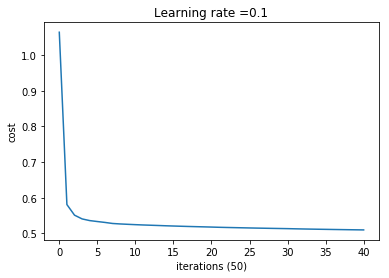

In [27]:
layers_dims = (12,100, 1)
conv_layer_dims=[(3,3),(2,1)]
parameters,tree ,train_test= N_layer_model(X_train,y_train,
                                layers_dims = layers_dims,
                                conv_layer_dims=conv_layer_dims,
                                num_iterations = 2001)

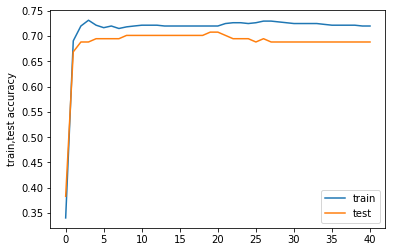

In [28]:
train,test =zip(*train_test)
plt.plot(np.squeeze(np.around(np.array(train).astype(float),decimals=4)))
plt.plot(np.around(np.array(test).astype(float),decimals=4))
plt.legend(['train','test'])
plt.ylabel('train,test accuracy')
plt.show()